# Intro

This is a notebook that is designed to create extremal mechanical materials based on the thiol-ene-epoxy multi-modulus chemistry created by Huang et. al.
It uses topology optimization and periodic homogenization to find unit cell designs that will maximize or minimize the compliance or stiffness on the macro scale depending on the input criteria.
It uses FEniCS, FEniCS adjoint, JAX and nlopt to perform the FEA, compute the gradients, and perform the optimization.
It's a Frankenstein's monster of a thing because it started out just using FEniCS adjoint and IPOPT, but then got progressively more sophisticated as I learned more about TO.

I am assuming you already have an understanding of extremal materials, if not you can go reference Graeme Milton's work, in particular "Which elasticity tensors are realizeable?" circa 1996 or 1994 or something.

The main way this differs from other inverse homgogenization TO is that we apply a secondary filter after the tanh projection step.
This is to emulate the actual modulus distribution that will result from the printing process because there is polymer diffusion and the modulus values aren't tight to the printed image.
The principal idea being that you can optimize to find the minimal width hinge possible because you are embedding a stiff material in a low stiffness matrix.

On the whole it's a pretty neat idea, but the polymer diffusion filtering was dificult to account for and nanoindentation tests were not all that illuminating in how quickly the modulus transitions from low to high and vice versa.

All the filtering and pre-processing gets handled by numpy/JAX, then the final "expected" output of the modulus values gets passed into FEniCS.
FEniCS adjoint is used to compute the gradient w.r.t. the filtered output, then we apply the JAX vjp to get the rest of the derivative.

In [1]:
from fenics import *
from fenics_adjoint import *

import nlopt
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output
import copy

from src.pde.utils import *
from src.pde.strain import linear_strain as eps, macro_strain as eps_macro
from src.top.AdjMatrix import AdjMatrix
from src.manufacturing.image import func2img, bitmapify, img2func
from src.pde.boundary import PeriodicDomain

set_log_level(40)
set_working_tape(Tape())
# np.set_printoptions(precision=4, suppress=False)
%matplotlib inline

COMM = MPI.comm_world
ISQR2 = 1. / np.sqrt(2.)

# Inputs

In [2]:
extremal_mode = 1
basis_v = "BULK"
symmetry_order = 'isotropic' 

obj_method = 'nullspace' # nullspace, energy, sum, ratio, or eigenvalue
unit_cell_size_mm = 15.
rho_seed = 'rand'
random_seed = 1 #np.random.randint(0, 1000)
erosion_method = 'tanh' # tanh or simp

NELEM = 50
FILTER_TYPE = 'density' # density or helmholtz
FILTER_RADIUS = .1 # First pass filter radius

# FE Problem Setup

## Model parameters

In [3]:
E_MIN, E_MAX = Constant(1e-3, name="E_MIN"), Constant(1., name="E_MAX")
NU = Constant(0.4, name="NU")
PEN = Constant(6.)
np.random.seed(random_seed)

pixel_size_mm = 0.05 # 50um
# min_feature_mm = 1. # min feature size estimated to be 1mm with 500um drop off in modulus on each side
min_feature_mm = 3.4 # new estimates
img_resolution = int(unit_cell_size_mm / pixel_size_mm)
print(f"Image resolution: {img_resolution}x{img_resolution}")
print(f"Minimum line width: {min_feature_mm} mm")
RMIN = min_feature_mm / unit_cell_size_mm / 2.
print(f"RMIN: {RMIN}")

if FILTER_TYPE == 'helmholtz':
    RMIN /= (2. * np.sqrt(3.))
    print(f"Filter RMIN: {RMIN}")

Image resolution: 300x300
Minimum line width: 3.4 mm
RMIN: 0.11333333333333333


## Mesh

Volume: 0.9999999999999062


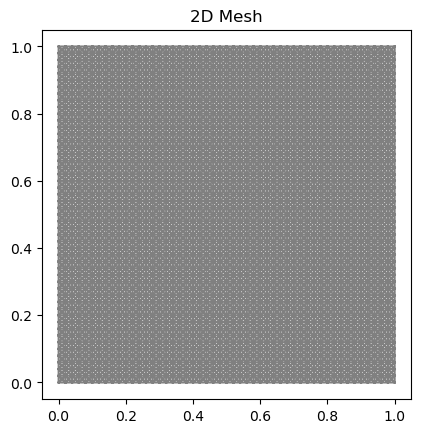

In [4]:
a, b = 1., 1. # model only works for square unit cell
mesh = RectangleMesh(COMM, Point(0, 0), Point(a, b), int(a*NELEM), int(b*NELEM), diagonal='crossed')
vol = assemble(Constant(1) * dx(domain=mesh))
print(f"Volume: {vol}")

plt.figure()
plot(mesh, title='2D Mesh')

# Simple plot for understanding the mesh and the cell ordering
if NELEM < 4:
    mids = [cell.midpoint() for cell in cells(mesh)]
    ids  = [cell.index() for cell in cells(mesh)]
    for mid, id in zip(mids, ids):
        plt.text(mid.x(), mid.y(), id)
        
    plt.scatter([m.x() for m in mids], [m.y() for m in mids], marker='x', color='red')

## Elasticity equations

We need to pass in a macroscopic strain into the stress function as well as pass in the density function to determine the Young's modulus as a function of space.

Our objective function is based on the homogenized C matrix (called `Chom`) so we also need a way to calculate that in a way that the adjoint method can utilize, which means ensuring everything is an AdjFloat or a UFL form.

In [5]:
def sigma(v, rho, eps_bar):
    
    def calculate_lame_parameters(E, nu, model='plane_stress'):
        mu_ = E / (2.0 * (1.0 + nu))
        if model == 'plane_stress':
            lambda_ = E * nu / ((1. - nu) * (1 + nu))
        elif model == 'plane_strain':
            lambda_ = E * nu / ((1.0 + nu) * (1.0 - 2.0*nu))
        else:
            raise ValueError(f"Incompatible material model {model}. Model must be 'plane_stress' or 'plane_strain")
        return lambda_, mu_    

    E = E_MIN + (E_MAX - E_MIN) * rho# ** PEN # SIMP can also be implemented previous to this function
    lambda_, mu_ = calculate_lame_parameters(E, NU, model='plane_stress')
    return lambda_*tr(eps(v) + eps_bar)*Identity(2) + 2.*mu_*(eps(v) + eps_bar)

def compute_homogenized_C(u_list: list, rho: Function) -> AdjMatrix:
    s_list = [sigma(u, rho, eps_macro(i)) for i, u in enumerate(u_list)]

    Chom_unassembled = [
        [
            inner(s_t, eps(u) + eps_macro(j))
            for j, u in enumerate(u_list)
        ]
        for s_t in s_list
    ]

    Chom = AdjMatrix([[assemble(c/vol * dx) for c in row] for row in Chom_unassembled])

    return Chom, Chom_unassembled

## Variational formulation

### Build elasticity function space

We use a mixed function space because we apply Lagrange multipliers instead of Dirichlet boundary conditions to prevent rigid body motion

In [6]:
element_degree = 1
Ve = VectorElement('CG', mesh.ufl_cell(), element_degree)
Re = VectorElement('R', mesh.ufl_cell(), 0)
W = FunctionSpace(mesh, MixedElement([Ve, Re]), constrained_domain=PeriodicDomain(mesh))
V = FunctionSpace(mesh, Ve)

### Build density function space

We use a DG function space so each cell has a constant density applied to it. This is how traditional SIMP TO is done.

#### Setup

In [7]:
def init_rho(R: FunctionSpace, seed: str = 'rand', vol_frac: float = 0.5, ):
    rmax, rmin = 1., 1e-3
    (xmax, ymax), (xmin, ymin) = R.mesh().coordinates().max(axis=0), R.mesh().coordinates().min(axis=0)
    if 'i' == seed[0]:
        rmax, rmin = rmin, rmax
        seed = seed[1:]
    shape = None
    if seed == 'rand':
        out = Function(R, name='rho')
        out.vector().set_local(np.random.choice([0., 1.], size=R.dim()))
        return out
    elif seed in ['circle', 'ellipse', 'periodcheck', 'triangle']:
        class Shape(UserExpression):
            def eval(self, values, x):
                xc, yc, rad = 0.5*xmax, 0.5*ymax, .3*min(xmax-xmin,ymax-ymin)
                if seed == 'circle':
                    values[0] = rmin if (x[0]-xc)**2 + (x[1]-yc)**2 <= rad**2 else rmax
                elif seed == 'periodcheck':
                    values[0] = rmin if x[0]**2 + x[1]**2 <= rad**2 else rmax
                elif seed == 'ellipse':
                    a, b = .4, .2
                    values[0] = rmin if (x[0]-xc)**2/a/a + (x[1]-yc)**2/b/b <= 1 else rmax
                elif seed == 'triangle':
                    def triangle(x, s, rmin, rmax):
                        # 2D "cross product"
                        def cross_product(p1, p2):
                            return p1[0] * p2[1] - p1[1] * p2[0]

                        if not 0 <= s <= 1:
                            raise ValueError("Side length s must be between 0 and 1")

                        # Height of the equilateral triangle
                        h = (np.sqrt(3) / 2) * s

                        # Vertices of the triangle
                        a = (0.5, (1 + h) / 2.)  # Top center
                        b = ((1 - s) / 2., (1 - h) / 2.)  # Bottom left
                        c = ((1 + s) / 2., (1 - h) / 2.)  # Bottom right

                        # Vectors from point to triangle vertices
                        ab = [b[0] - a[0], b[1] - a[1]]
                        bc = [c[0] - b[0], c[1] - b[1]]
                        ca = [a[0] - c[0], a[1] - c[1]]
                        ap = [x[0] - a[0], x[1] - a[1]]
                        bp = [x[0] - b[0], x[1] - b[1]]
                        cp = [x[0] - c[0], x[1] - c[1]]

                        # Cross products
                        cross1 = cross_product(ab, ap)
                        cross2 = cross_product(bc, bp)
                        cross3 = cross_product(ca, cp)

                        # Check if point is inside the triangle
                        if (cross1 >= 0 and cross2 >= 0 and cross3 >= 0) or (cross1 <= 0 and cross2 <= 0 and cross3 <= 0):
                            return rmin
                        else:
                            return rmax
                    values[0] = triangle(x, s=.7, rmin=rmin, rmax=rmax)
        shape = Shape(name="rho")
    elif seed == 'sandwich':
        class Sandwich(UserExpression):
            def eval(self, values, x):
                values[0] = rmax if x[1] > xmax*2./3. or x[1] < xmax*1./3. else rmin
        shape = Sandwich(name="rho")
    elif seed == 'flat':
        return interpolate(Constant(vol_frac), R)
    elif seed == 'shear':
        class Shear(UserExpression):
            def eval(self, values, x):
                if np.isclose(x[0], x[1], rtol=1e-3, atol=1e-1):
                    values[0] = rmax
                else:
                    values[0] = rmax if x[1] > xmax*2./3. or x[1] < xmax*1./3. else rmin
                
        shape = Shear(name="rho")
    elif seed == 'andre':
        img = 1. - plt.imread('images/andreassen_auxetic.png')
        return img2func(img, R.mesh(), R)        
    elif seed == 'dots':
        class Dots(UserExpression):
            def eval(self, values, x):
                xp, yp = x[0], x[1]
                xc, yc = (xmin + xmax) / 2, (ymin + ymax) / 2
                rad = min(xmax - xmin, ymax - ymin) / 5

                if (xp - xc) ** 2 + (yp - yc) ** 2 <= rad ** 2:
                    values[0] = rmin
                elif (xp - xmin)**2 + (yp - ymin)**2 <= rad**2:
                    values[0] = rmin
                elif (xp - xmax)**2 + (yp - ymin)**2 <= rad**2:
                    values[0] = rmin
                elif (xp - xmin)**2 + (yp - ymax)**2 <= rad**2:
                    values[0] = rmin
                elif (xp - xmax)**2 + (yp - ymax)**2 <= rad**2:
                    values[0] = rmin
                else:
                    values[0] = rmax

        shape = Dots(name="rho")   
    else:
        raise ValueError(f"Seed {seed} not implemented")

    return interpolate(shape, R)

def plot_density(rho: Function, title: str = 'Density', ax=None):
    r = Function(rho.function_space())
    # invert so colors match intuition
    # we do it this way because if we plot (1-rho) directly it 
    # will do some weird interploation
    # and not give use the sharp edges we want
    r.vector()[:] = 1. - rho.vector()[:]  
    r.set_allow_extrapolation(True)

    if isinstance(ax, plt.Axes):
        plt.sca(ax)
    else:
        fig, ax = plt.subplots()
    ax.margins(x=0, y=0)
        
    plot(r, cmap='gray', vmin=0., vmax=1., title=title)
    
def mirror(r):
    R = r.function_space()
    from scipy.spatial import KDTree
    tree = KDTree(R.tabulate_dof_coordinates())
    
    for c in cells(R.mesh()):
        cx, cy = c.midpoint().array()[:2]
        if cx < 0.5:
            _, i = tree.query([1. - cx, cy])
            r.vector()[c.index()] = r.vector()[i]

The code is really only set up to use a density filter, but Helmholtz is there for posterity. The density filter does a convolution with a conical filter (2D triangle wave), but here we do a precalculation to compute the convolution weights ahead of time. Then this ends up being just a single matrix multiplication instead of running a convolution each time. 

This is an expensive operation though, so the desnity filter class is setup to calculate the filter matrix and normalizing vector once and store it in a pickle files. Then if the mesh parameters and filter radius have already been used we can just load it, which is usualy faster than recomputing. If you run a lot of different filter parameters though the pkl file will get very large (GB size) and can become cumbersome. If that happens probably just delete it and start again.

In [8]:
from src.top.filter import DensityFilter, HelmholtzFilter

filter_dict = {
    'density': (DensityFilter, ('DG', 0)),
    'helmholtz': (HelmholtzFilter, ('CG', 1, None, PeriodicDomain(mesh))), # we use None because the constrained_domain kwarg is actually 4th
}

if FILTER_TYPE == 'density':
    filter_class, filter_fn_space_params = filter_dict[FILTER_TYPE]
    filter = filter_class(mesh, radius=FILTER_RADIUS, distance_method='periodic') # Filter used for density filter
    erosion_filter = filter_class(mesh, radius=RMIN, distance_method='periodic') # Filter used for modulus erosion
elif FILTER_TYPE == 'helmholtz':
    filter_class, filter_fn_space_params = filter_dict[FILTER_TYPE]
    filter = filter_class(radius=RMIN)
else:
    raise ValueError(f"Filter type must be one of {list(filter_dict.keys())}")

Loading filter from cache
Loading filter from cache


#### Function space

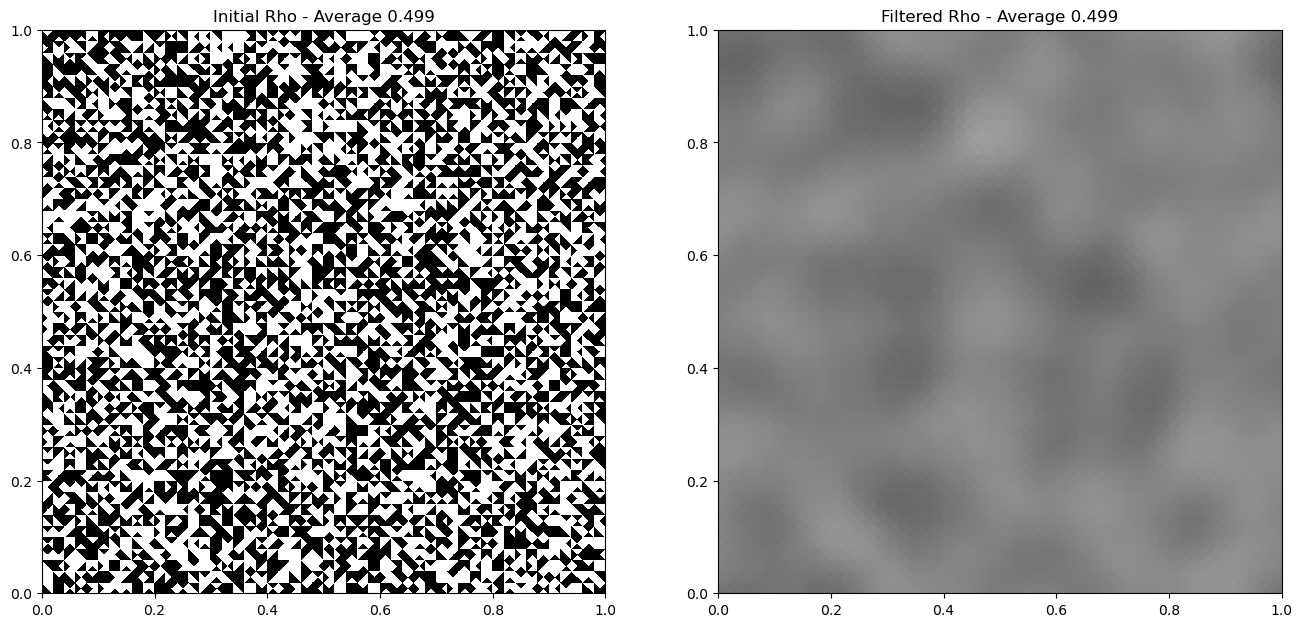

In [9]:
R = FunctionSpace(mesh, *filter_fn_space_params)
rho_phys = Function(R, name="Rho_phys") # actual rho we care about
rho_phys.assign(init_rho(R, seed=rho_seed))

with stop_annotating():
    rho_tmp = filter.filter(rho_phys)
    rho_tmp.rename('rho_tmp', 'rho_tmp')  
       

fig, ax = plt.subplots(1, 2, figsize=(16,8))
plot_density(rho_phys, title=f"Initial Rho - Average {np.mean(rho_phys.vector()[:]):.3f}", ax=ax[0])
plot_density(rho_tmp, title=f"Filtered Rho - Average {np.mean(rho_tmp.vector()[:]):.3f}",  ax=ax[1])

# Optimization Problem Setup

In [10]:
def jax_density_filter(x, H, Hs):
    return jnp.divide(H @ x, Hs)

def jax_projection(x, beta=1., eta=0.5):
    tanh_beta_eta = jnp.tanh(beta * eta)
    tanh_beta_x_minus_eta = jnp.tanh(beta * (x - eta))
    tanh_beta_one_minus_eta = jnp.tanh(beta * (1 - eta))

    numerator = tanh_beta_eta + tanh_beta_x_minus_eta
    denominator = tanh_beta_eta + tanh_beta_one_minus_eta

    return jnp.array(numerator / denominator)

def jax_simp(x, penalty):
    return jnp.power(x, penalty)

# old defaults: beta = 5.85, eta = 0.94
# new defaults: beta = 5.74, eta = 0.75 for a 3.4 min feature size
def jax_erosion(x, H, Hs, beta=5.74, eta=.75, erosion_method='tanh'):
    if erosion_method == 'simp':
        return jax_simp(jax_density_filter(x, H, Hs), float(PEN))
    elif erosion_method == 'tanh':
        return jax_projection(jax_density_filter(x, H, Hs), beta=beta, eta=eta)
    else:
        raise ValueError(f"Erosion method {erosion_method} not recognized")
        
def jax_filter(x, H, Hs, beta=1., eta=0.5):
    x_tilde = jax_density_filter(x, H, Hs)
    x_bar   = jax_projection(x_tilde, beta=beta, eta=eta)
    return jax_erosion(x_bar, H, Hs)
    
# useful for when we want to use two different filters, one for the TO process and one for the multi-modulus erosion
def double_filter(x, filter1p, filter2p, beta, eta=0.5, erosion_method='tanh'):
    H, Hs = filter1p
    x1 = jax_density_filter(x, H, Hs)
    x2 = jax_projection(x1, beta, eta)
    H, Hs = filter2p
    x3 = jax_erosion(x2, H, Hs, beta=5.85, eta=0.94, erosion_method=erosion_method)
    return x3

def solve_pde(r: Function):
    # print("Running forward...")
    v_, lamb_ = TestFunctions(W)
    dv, dlamb = TrialFunctions(W)
    
    eps_bar = Constant(((0., 0.),
                        (0., 0.)), name='Eps_macro')

    F = inner(sigma(dv, r, eps_bar), eps(v_))*dx
    a, L = lhs(F), rhs(F)
    a += dot(lamb_, dv)*dx + dot(dlamb, v_)*dx
    
    sols = []
    for (j, case) in enumerate(["Exx", "Eyy", "Exy"]):
        w = Function(W, name=f"w_sol_{case}")
        # print("Solving {} case...".format(case))
        eps_bar.assign(eps_macro(j))
        solve(a == L, w, [])
        v, _ = split(w.copy(deepcopy=True))
        sols.append(v)

    Chom, uChom = compute_homogenized_C(sols, r)
    
    return Chom

### Plotting routine

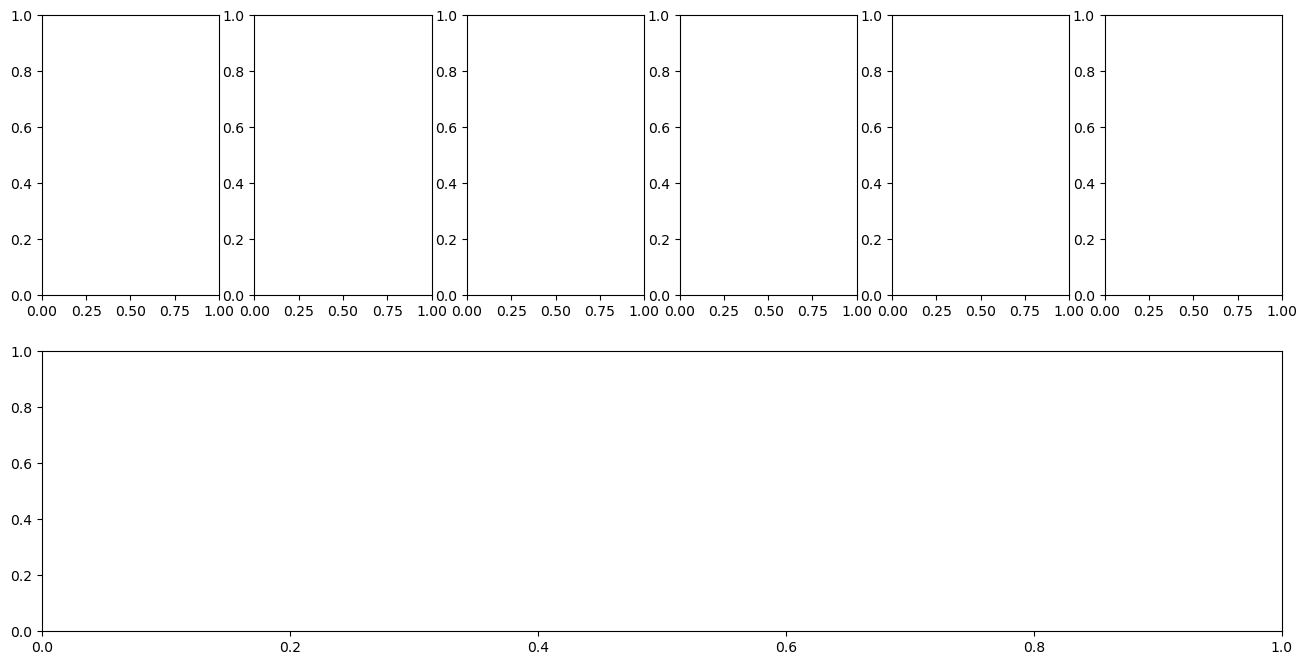

In [11]:
pad_data = lambda data: [i + [np.nan]*(len(max(data, key=len))-len(i)) for i in data]

def update_plot(fields, fig, ax1, ax2, obj_evals, constr_evals = [], epoch=0, epoch_iter_tracker=[]):
    assert len(ax1) == len(fields), "ax1 must be the same length as fields"
    clear_output(wait=True)
    r = Function(R)
    for ax, (name, field) in zip(ax1, fields.items()):
        if field.shape[0] == R.dim():
            r.vector()[:] = field
            plot_density(r, title=f"{name}", ax=ax)
        else:
            ax.imshow(255 - field, cmap='gray')
            ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])
    
    ax2.clear()
    obj_arr = np.array(obj_evals)
    ax2.plot(range(1, len(obj_evals) + 1), obj_arr, marker='o')
    for iter_val in epoch_iter_tracker:
        ax2.axvline(x=iter_val, color='black', linestyle='--', alpha=0.5, linewidth=3.)
    # ax2.plot(np.array(pad_data(constr_evals)), linestyle='--', marker='x')
    ax2.set(title=f'Epoch: {int(epoch)}, Objective Function ({obj_method}): {obj_evals[-1][0]:.3e}', 
            xlabel='Iteration', 
            ylabel='Objective Value',
            yscale='log',
            )
    ax2.grid(True)
    ax2.legend(["t", "e1", "e2", "e3"], loc='upper left')  # Add legend
    ax2.set_xlim(left=0, right=len(obj_evals) + 2)
    # sometimes t gets really large or small compared to the other values so we wnat to ignore it when considering y scaling
    # min_val = np.min(obj_arr[:, 1:])
    # max_val = np.max(obj_arr[:, 1:])
    min_val = np.min(obj_arr)
    max_val = np.max(obj_arr)
    buffer_factor = 0.2  # This can be adjusted as needed
    min_val *= (1 - buffer_factor)
    max_val *= (1 + buffer_factor)
    ax2.set_ylim([min_val, max_val])
    if len(constr_evals) > 0:
        if not hasattr(ax2, 'twin'):  # Check if 'twin' attribute exists
            ax2.twin = ax2.twinx()  # Create a twin Axes sharing the xaxis
        ax2.twin.clear()
        pad_constr_evals = np.array(pad_data(constr_evals))
        ax2.twin.plot(range(1, len(constr_evals) + 1), pad_constr_evals, marker='x', linestyle='--')
        ax2.twin.set(ylabel='Constraint values',
                     yscale='log')
        ax2.twin.set_xlim(left = 0, right = len(obj_evals) + 2)

    plt.tight_layout()
    display(fig)
    
import matplotlib.gridspec as gridspec

convergence_fig = plt.figure(figsize=(16,8))
grid_spec = gridspec.GridSpec(2, 6, )
ax1 = [plt.subplot(grid_spec[0, 0]), plt.subplot(grid_spec[0, 1]), plt.subplot(grid_spec[0, 2]), plt.subplot(grid_spec[0, 3]), plt.subplot(grid_spec[0, 4]), plt.subplot(grid_spec[0, 5])]

ax2 = plt.subplot(grid_spec[1, :])  # This plot spans across both columns

## Optimization Problem

## Bases

The code is set up so that the first column of the basis is either the compliant strain (unimode) or supporting stress (bimode). The names try to reflect this where BULK has the first vectore corresponding to a bulk strain/stress, etc. Some bases should produce equivalent designs, but because of the optimization process and noise at start can travel through different spaces so it makes sense to try out a few "equivalent" bases.

In [12]:
obj_evals, constr_evals = [], []
global_state = (None, None, None)

v_dict = {
    "BULK": np.array([[ISQR2, -ISQR2, 0.],
                      [ISQR2,  ISQR2, 0.],
                      [0.,     0.,    1.]]),
    "IBULK": np.array([[-ISQR2, ISQR2, 0.],
                     [ ISQR2, ISQR2, 0.],
                     [ 0.,    0.,    1.]]),
    "VERT": np.array([[0., 1., 0.],
                      [1., 0., 0.],
                      [0., 0., 1.]]),
    "VERT2": np.array([[0., ISQR2, -ISQR2],
                       [1., 0.,     0.],
                       [0., ISQR2,  ISQR2]]),
    "SHEAR": np.array([[0., -ISQR2, ISQR2],
                       [0.,  ISQR2, ISQR2],
                       [1.,  0.,    0.]]),
    "SHEARXY": np.array([[0., 1., 0.],
                         [0., 0., 1.],
                         [1., 0., 0.]]),
    "HSA": np.array([[0.,     0.,    1.],
                    [ISQR2, -ISQR2, 0.],
                    [ISQR2,  ISQR2, 0.]]),
    "HSA2": np.array([[0.,     0.,    1.],
                     [ISQR2,  ISQR2, 0.],
                      [-ISQR2, ISQR2, 0.]]),
    "IHSA": np.array([[1., 0., 0.],
                      [0., ISQR2, -ISQR2],
                      [0., ISQR2,  ISQR2]]),
    "EYE": np.eye(3),
}

v = v_dict.get(basis_v, "VERT")

In [13]:
class MinimaxProblem:
    """
    A class representing a minimax optimization problem.
    We reformulate the problem as a nonlinear optimization problem by adding a slack variable t as the objective function.
    
    min_x max{f1, f2, f3}
    s.t. g(x) <= 0
    
    becomes
    
    min_{x, t} t
    s.t. f1 <= t
         f2 <= t
         f3 <= t
         g(x) <= 0
         
    The objective function is the slack variable t.
    The gradiant of the objective function is then all zeros with a 1 at the end of the vector.
    """
    def __call__(self, x, grad):
        """
        Evaluates the objective function of the minimax problem.

        Parameters:
        - x: The input vector.
        - grad: The gradient vector.

        Returns:
        - The objective function value.
        """
        t = x[-1]
        
        if grad.size > 0:
            grad[:] = 0.
            grad[-1] = 1.
        
        return t

## Constraint Functions

In [14]:
class MinimaxConstraint:
    """
    This is the heavy lifting of the optimization routine.
    It is set up to be a vector constraint function of length 3.
    Usually there is one minimization term w.r.t. each vector of the basis v.
    
    There are 4 objective methods:
    - nullspace: minimizes the dot product of the basis vector and the homogenized matrices
    - energy: minimizes the energy of the basis vector in the homogenized matrices
    - sum: minimizes the sum of the energy of the basis vector in the homogenized matrices, this is closest to Milton's definition of extremal material
    - eigenvalue: attempting to find the smallest eigenvalue of the homogenized matrices
    
    Right now, the eigenvalue method is not working as intended, but the other 3 can give decent results.
    The nullspace method is the most reliable.
    """
    def __init__(self, v, extremal_mode, obj_method, beta = 1, check_derivatives=False, verbose=False, plot_delay=10, erosion_method='tanh', eps=1.):
        self.v = v
        self.extremal_mode = extremal_mode
        
        self.check_derivatives = check_derivatives
        self.verbose = verbose
        self.plot_delay = plot_delay
        
        self.beta = beta
        self.eta = 0.5
        self.eps = eps # not really meant to be changed
        self.obj_method = obj_method
        self.erosion_method = erosion_method
        
        self.epoch = 0
        self.epoch_iter_tracker = []

        self.n_constraints = 3
        self.dbdt = self.eps * np.ones(self.n_constraints)
        
        print(f"""
MinimaxConstraint initialized with:
v:
{v}
extremal_mode: {extremal_mode}
obj_method: {obj_method}
erosion_method: {erosion_method}
starting beta: {beta}
check_derivatives: {check_derivatives}
verbose: {verbose}
plot_delay: {plot_delay}
""")
        
        
    def __call__(self, results, x, grad, dummy_run=False):
        global global_state
        # reset the tape every call to avoid tape accumulation
        # there's probably a better way to do this but I don't know it
        set_working_tape(Tape())
        
        x, t = x[:-1], x[-1]

        # Forward
        x_hat, vjp = jax.vjp(lambda x: double_filter(x, 
                                                     (filter.H_jax, filter.Hs_jax), 
                                                     (erosion_filter.H_jax, erosion_filter.Hs_jax), 
                                                     beta=self.beta, 
                                                     eta=self.eta, 
                                                     erosion_method=self.erosion_method), 
                             x,)

        r = Function(R, name="Rho")
        r.vector().set_local(x_hat)
        Chom = solve_pde(r)
        # print(Chom)
        global_state = (Chom, r, vjp)
        
        s = AdjMatrix(np.diag([1., 1., np.sqrt(2)]))
        Chom = s @ Chom @ s # convert to Mandel notation
        Shom = Chom.inverse()
        # Quick and dirty way to flip extremal modes.
        # The notation won't follow anymore for bimodes b/c Chom <==> Shom now etc.
        if extremal_mode == 2:
            Chom, Shom = Shom, Chom
            
        # normalize by frobenius norm to bring eigenvalues in line between the two matrices
        Chom /= Chom.norm()
        Shom /= Shom.norm()

        v = AdjMatrix(self.v)
        
        if self.obj_method in ['nullspace', 'eigenvalue']:
            Cv = Chom @ v
            Sv = Shom @ v
            e1 = Cv[:, 0]
            e2 = Sv[:, 1]
            e3 = Sv[:, 2]
            if self.obj_method == 'nullspace':
                gs = [(e1.T @ e1).tr(), (e2.T @ e2).tr(), (e3.T @ e3).tr()]
            else:
                p1 = e1 - t*v[:,0]
                p2 = e2 - t*v[:,1]
                p3 = e3 - t*v[:,2]
                gs = [p1.normsq() - 1e-3, p2.normsq() - 1e-3, p3.normsq() - 1e-3]
                dt1 = -2. * (p1.T @ v[:,0]).tr()
                dt2 = -2. * (p2.T @ v[:,1]).tr()
                dt3 = -2. * (p3.T @ v[:,2]).tr()
                self.dbdt = np.array([dt1, dt2, dt3])
        elif self.obj_method in ['energy', 'sum', 'ratio', 'std']:
            vCv = v.T @ Chom @ v
            vSv = v.T @ Shom @ v
            e1, e2, e3 = vCv[0, 0], vSv[1, 1], vSv[2, 2]
            if self.obj_method == 'energy':
                gs = [e1, e2, e3]
            elif self.obj_method == 'ratio':
                gs = [vCv[0,0]/vCv[1,1], vCv[0,0]/vCv[2,2], vCv[0,0]/vCv[2,2]]
            elif self.obj_method == 'std':
                gs = [vCv[0,0], 1. - vCv[1,1], 1. - vCv[2,2]]
            else:
                gs = [e1 + e2 + e3, e1 + e2 + e3, e1 + e2 + e3]            
        else:
            raise ValueError(f"Objective method {self.obj_method} not recognized")
        
        if self.obj_method == 'eigenvalue':
            results[:] = np.array(gs)
        else: 
            results[:] = np.array(gs) - self.eps * t
        
        # halt run here if we're just checking values and don't care about being in the optimization loop
        if dummy_run:
            return
        
        # obj_evals append happens here because we want to append the values for a dummy_run check
        obj_evals.append([t, *gs])
        
        if grad.size > 0:
            m = Control(r)
            # we first calculate the FEM gradient through fenics adjoint then apply jax vjp to the result
            ghats = [ReducedFunctional(g, m) for g in gs]
            dgdxs = [vjp(ghat.derivative().vector().get_local())[0] for ghat in ghats]
            dgdxs = np.array(dgdxs)
            grad[:] = np.c_[dgdxs, -self.dbdt]

            if self.check_derivatives:
                # only checks if fenics can calculate the gradient, does nothing for jax
                print(f"Checking constraint {self.__str__()} derivatives...")
                h = Function(R)
                h.vector()[:] = 1e-3 * np.random.uniform(0., 1., R.dim())
                for i, ghat in enumerate(ghats):
                    print(f"Constraint {i}")
                    taylor_test(ghat, r, h)
                    
        if ((len(obj_evals) == 1) or (len(obj_evals) % self.plot_delay == 0)) and not self.check_derivatives:
            x_tilde = jax_density_filter(x, filter.H_jax, filter.Hs_jax)
            x_bar = jax_projection(x_tilde, self.beta, self.eta)
            r_img = Function(R)
            r_img.vector()[:] = x_bar
            x_img = np.flip(bitmapify(r_img, (a, b), (int(a*img_resolution), int(b*img_resolution))), axis=0)
            # fields are control, filtered, projected, bitmap, tiling, final eroded
            fields = {r'$\rho$': x, r'$\tilde{\rho}$': x_tilde, 
                      r'$\bar{\rho},~\beta$=' + 
                      f"{int(self.beta)}": x_bar, 
                      f'Bitmap, L: {unit_cell_size_mm:.1f}, ({img_resolution:d}x{img_resolution:d})': x_img, 
                      'Tiling': np.tile(x_img, (3, 3)),
                      r'$\hat{\rho}$': x_hat, 
                      }
            update_plot(fields, convergence_fig, ax1, ax2, obj_evals, constr_evals, self.epoch, self.epoch_iter_tracker)

        print(f"{len(obj_evals):d} -- t: {t:.3e} -- gs: {gs}")

In [15]:
class VectorConstraint():
    '''
    This is a generalized class that will handle vector constraints for nlopt.
    It can also be used for a scalar constraint with vector of length 1.
    
    A constraint is formulated as g_k(x) <= b_k(x).
    We rearrange to give nlopt the form g_k(x) - b_k(x) <= 0.
    The simplified case is where b_k(x) = 0.
    This is the assumed default b/c we set dbdt = 0. on initialization.

    One thing we may wish to do is in a minimax problem we can bound using the optimization variable `t`.
    The interface for constraints and bounds takes this into account, but it could be more general in the future.
    e.g. right now the bounds functions are assumed to only take t, but something like b_k(Chom, x, t) and discarding unused inputs is viable.

    We use a global Chom, r and vjp here because it prevents us from having to rerun the forward pass again for the constraint.
    If we wrapped everything into one large class this could just be a class attribute that gets passed around.
    '''
    def __init__(self, check_derivatives=False, eps=1e-6, verbose=False):
        self.constraints = []
        self.check_derivatives = check_derivatives
        self.eps = eps
        self.verbose = verbose
        self.dbdt = np.zeros(self.n_constraints)
        self.bounds = None
            
    def __call__(self, results, x, grad, dummy_run=False):
        global global_state
        Chom, r, vjp = global_state
        x, t = x[:-1], x[-1]
        
        # Convert to Mandel
        # TODO: Somehow make this ubiquitous so I don' thave to remember it everywhere
        # probably bake in into the compute_homogenized_C function
        s = AdjMatrix(np.diag([1., 1., np.sqrt(2)]))
        Chom = s @ Chom @ s
        
        # values
        # list form in case we want to check derivatives later
        gs = [c(Chom) for c in self.constraints]
        bs = np.array([b(t) for b in self.bounds])
                
        results[:] = np.array(gs) - bs
        
        if dummy_run:
            return
        
        if self.verbose:
            print(f"{self.__str__()} value(s): {gs}")
            print(f"{self.__str__()} bound(s): {bs}")
        
        while len(constr_evals) < len(obj_evals):
            constr_evals.append([])
        constr_evals[-1].extend(gs)
        
        if grad.size > 0:
            m = Control(r)
            ghats = [ReducedFunctional(g, m) for g in gs]
            dgdxs = [vjp(ghat.derivative().vector().get_local())[0] for ghat in ghats]
            grad[:] = np.c_[np.array(dgdxs), -self.dbdt]

            if self.check_derivatives:
                print(f"Checking constraint {self.__str__()} derivatives...")
                h = Function(R)
                h.vector()[:] = 1e-3 * np.random.uniform(0., 1., R.dim())
                for i, ghat in enumerate(ghats):
                    print(f"Constraint {i}")
                    taylor_test(ghat, r, h)
                    
    @property
    def n_constraints(self):
        return len(self.constraints)
    
    def __str__(self):
        return "MinimaxConstraints"

In [16]:
class EigenvalueConstraint(VectorConstraint):
    '''
    This constraint was an attempt to guide eigenvalues.
    The whole goal of the optimization is so that the basis v is the eigenvectors of the homogenized matrix.
    v.T @ Chom @ v will yield a diagonal matrix as long as v is the eigenvectors of Chom.
    '''
    def __init__(self, v, extremal_mode, **kwargs):
        super().__init__(**kwargs)
        
        self.v = AdjMatrix(v)
        self.extremal_mode = extremal_mode
        if self.extremal_mode not in [1, 2]:
            raise ValueError("Extremal mode must be 1 or 2.")
        
        self.constraints = [self.c1, self.c2]
        # self.bounds = [lambda t: self.eps * t, lambda t: self.eps * t]
        # self.dbdt = np.array([self.eps, self.eps])
        self.bounds = [lambda t: self.eps, lambda t: self.eps]
        self.dbdt = np.zeros(self.n_constraints)
        
    def compute_D_(self, A):
        if self.extremal_mode == 2:
            A = A.inverse()
        A /= A.norm()
        D = self.v.T @ A @ self.v
        return D

    # first eigenvalue should be smallest
    def c1(self, A):
        D = self.compute_D_(A)
        print("D", D)
        return D[0, 0] - D[1, 1]
    
    # other two eigenvalues should be close
    def c2(self, A):
        D = self.compute_D_(A)
        return (D[1, 1] - D[2, 2])**2

    def __str__(self):
        return f"EigenvalueConstraint_M-{self.extremal_mode:d}"

In [17]:
class EigenvectorConstraint(VectorConstraint):
    """
    A class representing a constraint based minimzing the off diagonal terms of a matrix.
    The idea is that if v is a matrix of eigenvectors for A, then v.T @ A @ v = D will be a diagonal matrix.

    Parameters:
    - v: The matrix of the desired eigenvectors.
    - kwargs: Additional keyword arguments for parent class.

    Attributes:
    - v: The matrix of the desired eigenvectors.
    - constraints: A list of constraint functions.
    - bounds: A list of bounds functions.
    - dbdt: The rate of change of the bound with respect to minimax variable t.

    Notes:
    - We don't worry about extremal modes here because the eigenvectors of A are the same as the eigenvectors of A^-1.
    """

    def __init__(self, v, **kwargs):
        super().__init__(**kwargs)

        self.v = AdjMatrix(v)
        
        self.constraints = [self.c]
        self.bounds = self.n_constraints * [lambda t: self.eps * t]
        self.dbdt = np.ones(self.n_constraints) * self.eps
        
    def c(self, A):
        A /= A.norm()
        # D = self.v.T @ A @ self.v
        # print("D\n", D) if self.verbose else None
        # return sum(D[i,j]**2 /((D[i,i] + D[j,j]) / 2.) ** 2 for i in range(3) for j in range(3) if i != j)
        
        VAV = self.v.T @ A @ self.v
        return sum(VAV[i,j]**2 for i in range(3) for j in range(3) if i != j)**0.5
        

    def __str__(self):
        return "EigenvectorConstraint"

In [18]:
class EigenDecompConstraint(VectorConstraint):
    '''

    '''
    def __init__(self, v, extremal_mode, **kwargs):
        super().__init__(**kwargs)
        
        self.v = AdjMatrix(v)
        self.extremal_mode = extremal_mode
        if self.extremal_mode not in [1, 2]:
            raise ValueError("Extremal mode must be 1 or 2.")
        
        # self.constraints = [self.c1, self.c2, self.c3]
        self.constraints = [self.c3]
        self.bounds = [lambda t: t * self.eps]
        self.dbdt = np.zeros(self.n_constraints)
        
    def compute_D_(self, A):
        if self.extremal_mode == 2:
            A = A.inverse()
        A /= A.norm()
        D = self.v.T @ A @ self.v
        return D

    # first eigenvalue should be smallest
    def c1(self, A):
        D = self.compute_D_(A)
        # print("D", D)
        # return D[0, 0] - D[1, 1]
        return D[0, 0] / ((D[1, 1] + D[2, 2]) / 2.)
       
    # other two eigenvalues should be close
    def c2(self, A):
        D = self.compute_D_(A)
        return (D[1, 1] - D[2, 2])**2
    
    def c3(self, A):
        D = self.compute_D_(A)
        return sum(D[i,j]**2 for i in range(3) for j in range(3) if i != j)**0.5

    def __str__(self):
        return f"EigenDecompConstraint_M-{self.extremal_mode:d}"

In [19]:
class MaterialSymmetryConstraints(VectorConstraint):
    """
    Enforcing material symmetry can be done in a number of ways.
    For example, Andreassen et al. used one scalar constraint on the whole homogenized matrix, but here we implement each constraint as a separate function.
    
    The terminology and constraints are based on Trageser and Seleson paper.
    https://csmd.ornl.gov/highlight/anisotropic-two-dimensional-plane-strain-and-plane-stress-models-classical-linear
    """
    def __init__(self, symmetry_order='oblique', **kwargs):
        super().__init__(**kwargs)
        self.symmetry_order = symmetry_order
        
        self.symmetry_types_ = ['oblique', 'rectangular', 'square', 'isotropic']
        
        if self.symmetry_order not in self.symmetry_types_:
            raise ValueError(f"Material symmetry must be one of {self.symmetry_types_}")
        
        if self.symmetry_order in self.symmetry_types_[1:]:
            self.constraints.extend([lambda Chom: (Chom[0, 2]/Chom.tr())**2, lambda Chom: (Chom[1, 2]/Chom.tr())**2])
        if self.symmetry_order in self.symmetry_types_[2:]:
            self.constraints.append(lambda Chom: (1. - Chom[1, 1]/Chom[0, 0])**2)
        if self.symmetry_order == 'isotropic':
            self.constraints.append(lambda Chom: (1. - Chom[0, 1]/Chom[0, 0] - Chom[2, 2]/Chom[0, 0])**2)
        
        # self.bounds = self.n_constraints * [lambda t: self.eps]
        # self.dbdt = np.zeros(self.n_constraints)
        self.bounds = self.n_constraints * [lambda t: self.eps * t]
        self.dbdt = np.ones(self.n_constraints) * self.eps
        # self.bounds = self.n_constraints * [lambda t: self.eps]
        # self.dbdt = np.zeros(self.n_constraints)
        
    def __str__(self):
        return f"MaterialSymmetryConstraints_{self.symmetry_order}"
       

# Optimization

## Setup

In [20]:
check_derivatives = False # check if fenics adjoint is computing the gradients correctly
constrained = symmetry_order != 'oblique' # if oblique there isn't actually any constraint so no need to add it to the optimizer
EPOCH_ITER = 100
start_beta, n_betas = 16, 3
betas = start_beta * np.array([2**n for n in range(n_betas)])
betas = np.append(betas, betas[-1])
# if it's constrained we usually want to start with a loose symmetry constraint and dial it up later
# this helps keep us from ending up in a place where the symmetry of th cell isn't feasible at the end
loose_eps, tight_eps = 1., 1e-2
dim = R.dim() + 1 # number of rho variables + 1 for t

f = MinimaxProblem()
g_minimax = MinimaxConstraint(v=v, 
                      beta=start_beta, 
                      obj_method=obj_method, 
                      erosion_method=erosion_method, 
                      extremal_mode=extremal_mode, 
                      check_derivatives=check_derivatives, 
                      verbose=True,)
g_sym = MaterialSymmetryConstraints(symmetry_order=symmetry_order, 
                                eps=loose_eps, 
                                check_derivatives=check_derivatives, 
                                verbose=True)

g_vec = EigenvectorConstraint(v=v, 
                              eps=loose_eps,
                              check_derivatives=check_derivatives, 
                              verbose=True)

g_eig = EigenDecompConstraint(v=v,
                              eps=tight_eps,
                              check_derivatives=check_derivatives,
                              verbose=True,
                              extremal_mode=extremal_mode)

opt = nlopt.opt(nlopt.LD_MMA, dim)
opt.set_min_objective(f)

active_constraints = []
active_constraints.append(g_minimax)
# active_constraints.append(g_sym) if constrained else None
# active_constraints.append(g_vec)
# active_constraints.append(g_eig)
    
for constraint in active_constraints:
    print(f"Adding constraint {constraint.__str__()} to optimizer...")
    opt.add_inequality_mconstraint(constraint, np.zeros(constraint.n_constraints))

# bounds
# rho is bounded between 0 and 1, t is bounded between 1e-6 and inf
lb = np.zeros(dim)
lb[-1] = 1e-6
opt.set_lower_bounds(lb)
ub = np.ones(dim)
ub[-1] = np.inf
opt.set_upper_bounds(ub)

opt.set_maxeval(EPOCH_ITER)
opt.set_param('inner_maxeval', 1_000)
opt.set_param('dual_maxeval',  1_000)
# opt.set_param('verbosity', 1)


MinimaxConstraint initialized with:
v:
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]
extremal_mode: 1
obj_method: nullspace
erosion_method: tanh
starting beta: 16
check_derivatives: False
verbose: True
plot_delay: 10

Adding constraint <__main__.MinimaxConstraint object at 0x7ff81bae5f90> to optimizer...


In [21]:
start_str = f"""
Starting optimization...
Unit cell size (mm): {unit_cell_size_mm:.1f}
Objective method: {obj_method}
Erosion method: {erosion_method}
Extremal mode: {extremal_mode}
Epoch iterations: {EPOCH_ITER}
Tight eps: {tight_eps}
Loose eps: {loose_eps}
Constrained: {"Yes" if constrained else "No"}
Basis v: {basis_v}
Symmetry order: {symmetry_order}
Rho seed: {rho_seed}
Betas: {betas}
"""
print(start_str)


Starting optimization...
Unit cell size (mm): 15.0
Objective method: nullspace
Erosion method: tanh
Extremal mode: 1
Epoch iterations: 100
Tight eps: 0.01
Loose eps: 1.0
Constrained: Yes
Basis v: BULK
Symmetry order: isotropic
Rho seed: rand
Betas: [16 32 64 64]



## Run

In [22]:
# when an epoch changes or we change beta the constraint values can jump
# and because the constraints can also be clamped by t we need to make sure
# that we start the epoch in a feasible state. 
# Basically t could be too low for the constraints to be satisfied and the 
# optimizer will spend cycles trying to get t up to a feasible value.
# We avoid this by jumping t to a feasible value at the start of each epoch.
def update_t(x, gs):
    print(f"Updating t...\nOld t value {x[-1]:.3e}")
    new_t = -np.inf
    x[-1] = 0.
    for g in gs:
        results = np.zeros(g.n_constraints)
        g(results, x, np.array([]), dummy_run=True)
        new_t = max(new_t, np.max(results)/g.eps)
    x[-1] = new_t
    print(f"New t value: {x[-1]:.3e}")

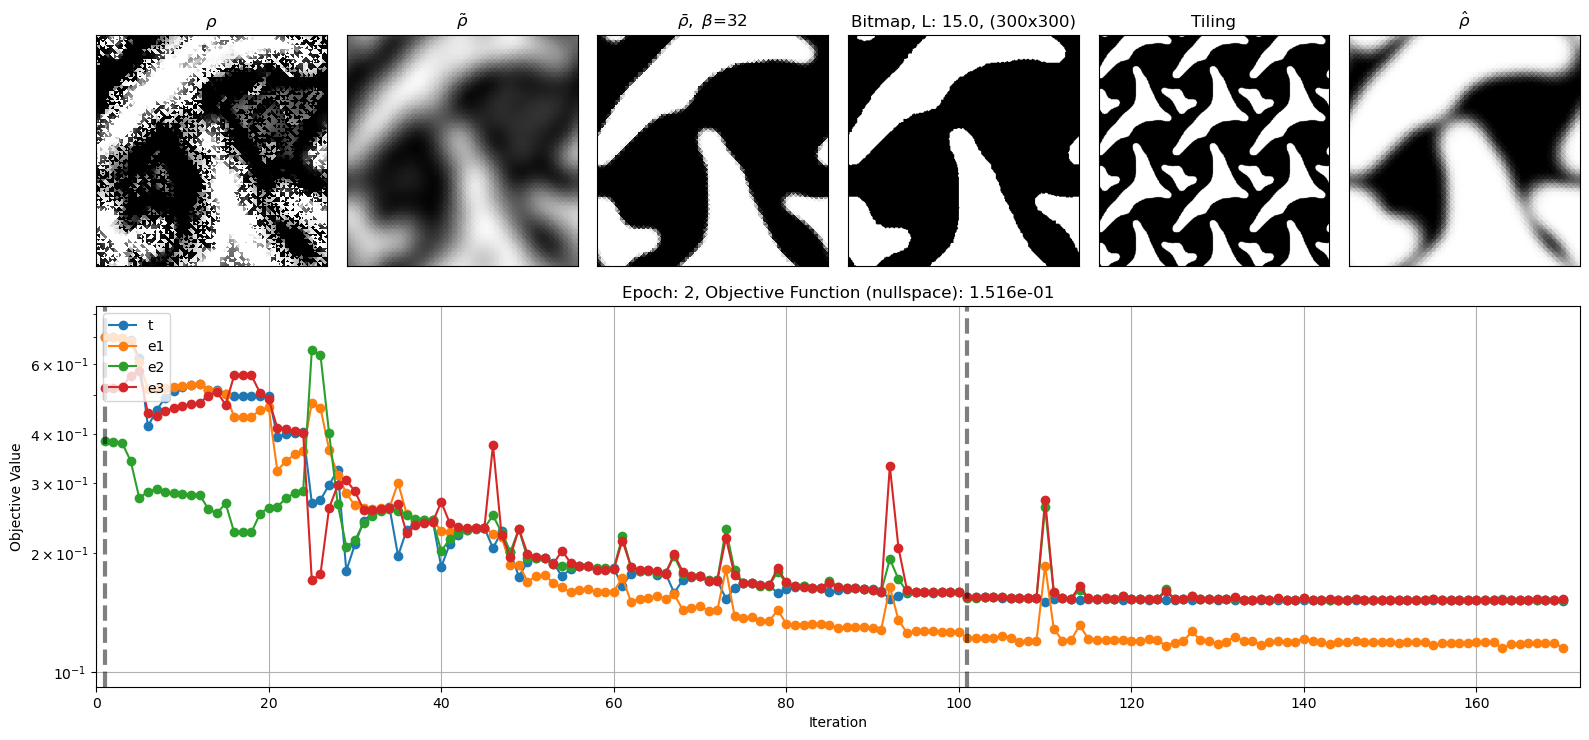

170 -- t: 1.516e-01 -- gs: [0.1154265815331173, 0.15207784769620664, 0.15257871687106317]
171 -- t: 1.518e-01 -- gs: [0.1174981113027711, 0.15181834285178106, 0.15181469823530117]
172 -- t: 1.517e-01 -- gs: [0.11794786902762823, 0.1518083825002119, 0.15177119037552944]
173 -- t: 1.518e-01 -- gs: [0.11773863004859314, 0.15177058160786783, 0.1517672148569732]
174 -- t: 1.516e-01 -- gs: [0.11561810899650353, 0.15186676290982756, 0.1522369643018624]
175 -- t: 1.517e-01 -- gs: [0.117177130889408, 0.1517243565968754, 0.15172393044413512]
176 -- t: 1.514e-01 -- gs: [0.12157989613508892, 0.15320464627878583, 0.15361186324638865]
177 -- t: 1.517e-01 -- gs: [0.11798292063059337, 0.15172078272409917, 0.15170887338124225]
178 -- t: 1.517e-01 -- gs: [0.11755979229915797, 0.15169231832813004, 0.15169158001397576]


KeyboardInterrupt: 

In [23]:
x = np.append(rho_phys.vector().get_local(), 0.) # rho + t, dim = R.dim() + 1
x_history = [np.copy(x)]

# first epoch is at least 100 to allow it to converge to a decent place before jumping beta
opt.set_maxeval(max(100, EPOCH_ITER))
for e, beta in enumerate(betas, 1):
    # prepare for the epoch
    g_minimax.epoch, g_minimax.beta = e, beta
    g_minimax.epoch_iter_tracker.append(len(obj_evals)+1) # this gives us the gray dashed lines on the plot
    update_t(x, active_constraints) # update after beta update because a beta jump can throw off the minimax objective functions
    
    # run
    x_optimized = opt.optimize(x)
    x_history.append(np.copy(x_optimized))
    x = np.copy(x_optimized)
    opt.set_maxeval(EPOCH_ITER) # not needed every loop but it doesn't hurt
    
    # tighten up the constraints for the final epoch
    if (e == len(betas) - 1):    
        opt.set_maxeval(max(200, EPOCH_ITER))
        active_constraints.append(g_eig)
        opt.add_inequality_mconstraint(g_eig, np.zeros(g_eig.n_constraints))
        g_eig.eps = tight_eps

# Check solution

In [ ]:
from scipy.optimize import linear_sum_assignment

def align_and_calculate_error(A, B):
    # Compute the absolute dot product of vectors in A and B
    dot_product_matrix = np.abs(A.T @ B)
    
    # Use the Hungarian algorithm to find the optimal assignment
    _, col_ind = linear_sum_assignment(-dot_product_matrix)
    
    # Reorder and flip signs in B according to the optimal assignment
    best_B = np.array([np.sign(A[:, i] @ B[:, j]) * B[:, j] for i, j in enumerate(col_ind)]).T
    
    # Calculate the error between each pair of columns in A and best_B
    errors = np.linalg.norm(A - best_B, axis=0)
    
    return best_B, errors

In [ ]:
s = np.diag([1., 1., np.sqrt(2)])

with stop_annotating():
    x_hat = double_filter(x_history[-1][:-1], (filter.H_jax, filter.Hs_jax), (erosion_filter.H_jax, erosion_filter.Hs_jax), g_minimax.beta, g_minimax.eta)
    r = Function(R, name="Rho")
    r.vector().set_local(x_hat)
    final_Chom = solve_pde(r)

E1, E2, G, nu12, eta122, nu21, eta121 = calculate_elastic_properties(np.array(final_Chom.matrix), input_style='standard')

eig_vals, eig_vecs = np.linalg.eigh(s @ np.array(final_Chom.matrix) @ s)

rearranged_eig_vecs, _ = align_and_calculate_error(v, eig_vecs)

with stop_annotating():
    solid_Chom = solve_pde(interpolate(Constant(1.), R))
    solid_eig_vals, _ = np.linalg.eigh(s @ np.array(solid_Chom.matrix) @ s)

data_str = f"""
===== {extremal_mode}-mode Input Basis =====
{v}
===== Output basis =====
{rearranged_eig_vecs}
===== Optimized Chom =====
{np.array(final_Chom.matrix)}
===== Diagonal D =====
{np.array(s.T @ v.T @ final_Chom.matrix @ v @ s)}
===== Matrix Properties =====
E1: {E1:.3f}, E2: {E2:.3f} G: {G:.3f}, nu12: {nu12:.2f}, nu21: {nu21:.2f}, eta122: {eta122:.2f}, eta121: {eta121:.2f}
Eigenvalues: {eig_vals}
Normalized eigenvalues: {eig_vals / np.max(solid_eig_vals)}
Relative eigenvalues: {eig_vals / np.max(eig_vals)}
Invariants: {np.array([final_Chom.det(), 0.5*(final_Chom.tr()**2 - (final_Chom@final_Chom).tr()), final_Chom.tr()])}
ASU: {anisotropy_index(np.array(final_Chom.matrix), input_style='standard')[-1]:.3e}
"""

print(data_str)


===== 1-mode Input Basis =====
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]
===== Output basis =====
[[ 0.6905047  -0.72288933 -0.02518502]
 [ 0.72324075  0.68946236  0.03955335]
 [-0.01122857 -0.0455266   0.99890002]]
===== Optimized Chom =====
[[ 2.85555467e-02 -8.71471593e-03  2.05167910e-04]
 [-8.71471593e-03  2.77416475e-02 -7.15835818e-05]
 [ 2.05167910e-04 -7.15835818e-05  1.53726567e-02]]
===== Diagonal D =====
[[ 0.01943388 -0.00040695  0.00013358]
 [-0.00040695  0.03686331 -0.00027675]
 [ 0.00013358 -0.00027675  0.03074531]]
===== Matrix Properties =====
E1: 0.026, E2: 0.025 G: 0.015, nu12: -0.31, nu21: -0.31, eta122: -0.01, eta121: 0.00
Eigenvalues: [0.01942296 0.03073399 0.03688556]
Normalized eigenvalues: [0.01165377 0.01844039 0.02213134]
Relative eigenvalues: [0.52657347 0.83322549 1.        ]
Invariants: [1.10093250e-05 1.58162186e-03 7.16698509e-02]
ASU: 1.195e-02



# Export

## Post-process $\rho$ for image

Cell size 15.00 mm
Image size: 300 x 300
Pixel size: 0.05 mm
UNIMODE_RAND-1EROSION-TANH_NELEM-50_OBJ-ratio_RE-0.113_RD-0.100_SYMM-isotropic_ELEM_DEG-1_EPOCHS-3_MINIMAX


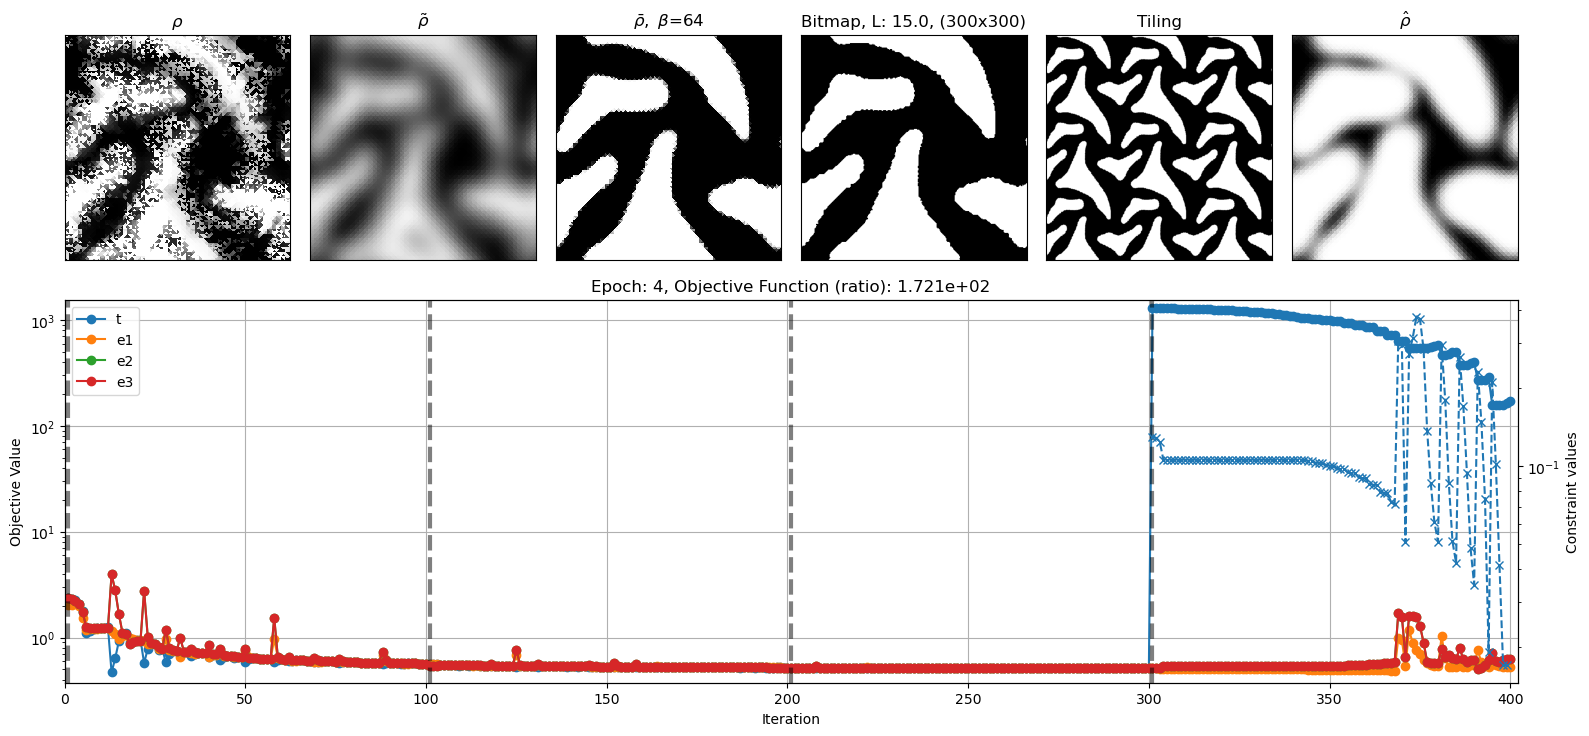

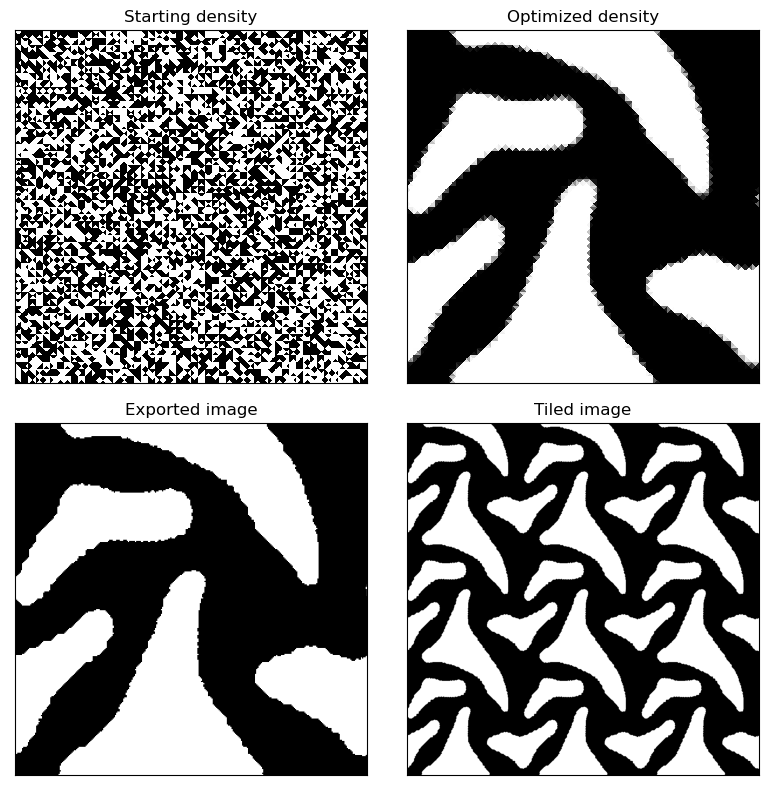

In [ ]:
import os
dir = os.getcwd()
img_dir = os.path.join(dir, "images", "$unimode" if extremal_mode == 1 else "$bimode", basis_v, symmetry_order.upper())
os.makedirs(img_dir, exist_ok=True)

print(f"Cell size {unit_cell_size_mm:.2f} mm")
print(f"Image size: {img_resolution:d} x {img_resolution:d}")
print(f"Pixel size: {pixel_size_mm:.2f} mm")

density_fig, _ = plt.subplots(figsize=(8, 8))

plt.subplot(221)
plot_density(rho_phys, title='Starting density', ax=plt.gca())

plt.subplot(222)
x_bar = jax_projection(jax_density_filter(x_history[-1][:-1], filter.H_jax, filter.Hs_jax), g_minimax.beta, g_minimax.eta)    
rho_bar = Function(R)
rho_bar.vector()[:] = x_bar
plot_density(rho_bar, title='Optimized density', ax=plt.gca())

plt.subplot(223)
# The control rho may be very noisy still so we filter it using the density filter before downsampling it 
# to the image resolution. This is really only an issue for image sizes on the order of NELEM.
r = Function(R)
# r.vector()[:] = jax_density_filter(xs[-1][:-1], filter.H_jax, filter.Hs_jax)
r.vector()[:] = x_bar
rho_img = bitmapify(r, (a, b), (int(a*img_resolution), int(b*img_resolution)))
plt.imshow(255 - rho_img, cmap='gray', origin='lower')
plt.gca().set(title='Exported image')

plt.subplot(224)
plt.imshow(255 - np.tile(rho_img, (3, 3)), cmap='gray', origin='lower')
plt.gca().set(title='Tiled image')

for ax in density_fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

fname =  "UNIMODE" if extremal_mode == 1 else "BIMODE"
fname += f"_{rho_seed.upper()}-{random_seed:d}"
fname += f"EROSION-{erosion_method.upper()}"
fname += f"_NELEM-{NELEM:d}"
fname += f"_OBJ-{obj_method}"
fname += f"_RE-{RMIN:.3f}"
fname += f"_RD-{FILTER_RADIUS:.3f}"
fname += f"_SYMM-{symmetry_order}"
fname += f"_ELEM_DEG-{element_degree:d}"
fname += f"_EPOCHS-{n_betas:d}"
fname += "_MINIMAX"
print(fname)
convergence_fig.savefig(os.path.join(img_dir, fname + "-CONVERGENCE.png"))
density_fig.savefig(os.path.join(img_dir, fname + "-DENSITY.png"))
from matplotlib.image import imsave
imsave(os.path.join(img_dir, fname + "-CELL.png"), rho_img, cmap='gray')

with open(os.path.join(img_dir, fname + ".txt"), 'w') as f:
    f.write(start_str)
    f.write(data_str)

import pickle
obj = {'x_history': x_history, 'obj_evals': obj_evals, 'constr_evals': constr_evals}
with open(os.path.join(img_dir, fname + "-data.pkl"), 'wb') as f:
    pickle.dump(obj, f)

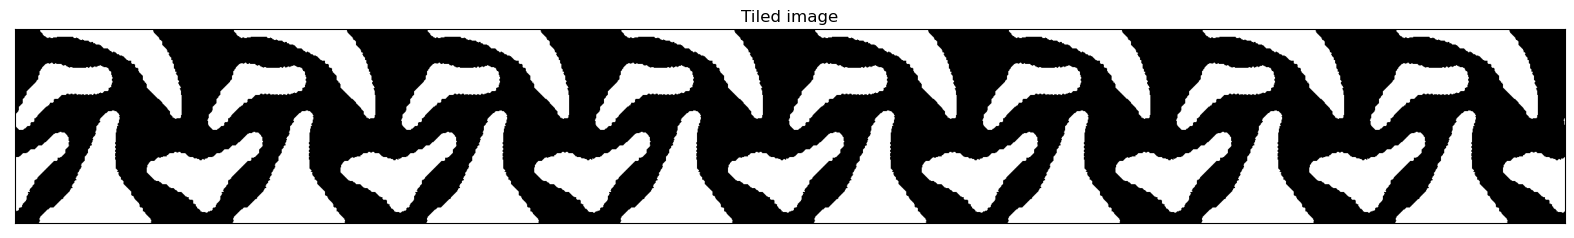

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
array_width_mm, array_height_mm = 120., 20.
nx, ny = int(array_width_mm/unit_cell_size_mm), int(array_height_mm/unit_cell_size_mm)
tiled_image = np.tile(rho_img, (ny, nx))
ax.imshow(255 - tiled_image, cmap='gray', origin='lower')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Tiled image')
plt.imsave(os.path.join(img_dir, fname + "-ARRAY.png"), tiled_image, cmap='gray')

Done!


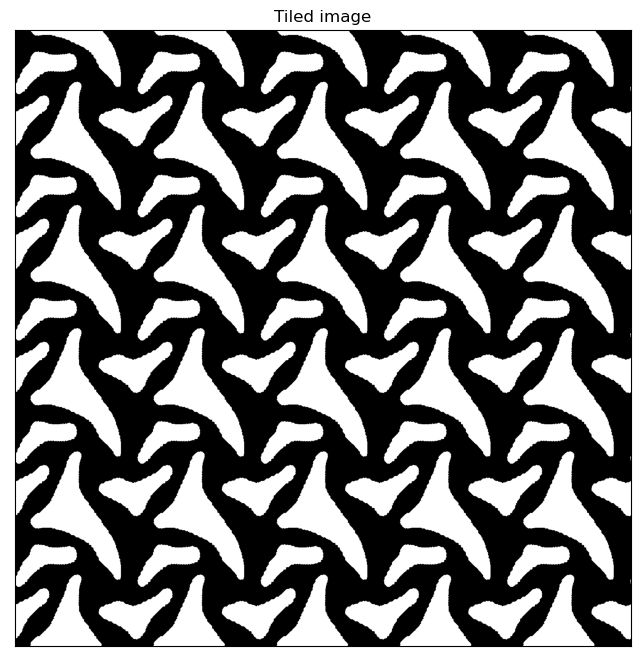

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
array_width_mm, array_height_mm = 75., 75.
nx, ny = int(array_width_mm/unit_cell_size_mm), int(array_height_mm/unit_cell_size_mm)
tiled_image = np.tile(rho_img, (ny, nx))
ax.imshow(255 - tiled_image, cmap='gray', origin='lower')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Tiled image')
plt.imsave(os.path.join(img_dir, fname + "-BIG-ARRAY.png"), tiled_image, cmap='gray')
print("Done!")